# Profiling with onnxruntime

The notebook profiles the execution of an ONNX graph built from a *KMeans* model and executed with *onnxruntime*. It then study the decomposition of one einsum equation into more simple operators.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## KMeans

### Builds a KMeans

In [4]:
from sklearn.datasets import make_classification
X, y = make_classification(100000)

In [5]:
from sklearn.cluster import KMeans
km = KMeans(max_iter=10)
km.fit(X)

KMeans(max_iter=10)

In [6]:
import numpy
from mlprodict.onnx_conv import to_onnx
onx = to_onnx(km, X[:1].astype(numpy.float32))

In [7]:
%onnxview onx

### Json

Another way to look into a model.

In [8]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(onx)
js = oinf.to_json()

In [9]:
import json
from io import StringIO
from jyquickhelper import JSONJS
JSONJS(json.load(StringIO(oinf.to_json())))

### Profiling

In [10]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(onx, runtime="onnxruntime1",
                     runtime_options={"enable_profiling": True})

In [11]:
for i in range(0, 111):
    oinf.run({"X": X.astype(numpy.float32)})

In [12]:
df = oinf.get_profiling(as_df=True)
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_provider,args_graph_index,args_parameter_size,args_thread_scheduling_stats,args_exec_plan_index,args_activation_size,args_output_size
0,Session,106368,299276,596,12,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,106368,299276,6925,670,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,106368,299276,1,34854,X,Re_ReduceSumSquare_fence_before,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,106368,299276,2939,34869,X,Re_ReduceSumSquare_kernel_time,ReduceSumSquare,CPUExecutionProvider,0,0,{'main_thread': {'thread_pool_name': 'session-...,0,8000000,400000
4,Node,106368,299276,0,37872,X,Re_ReduceSumSquare_fence_after,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,Node,106368,299276,0,2394227,X,Ar_ArgMin_fence_before,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2551,Node,106368,299276,3511,2394228,X,Ar_ArgMin_kernel_time,ArgMin,CPUExecutionProvider,5,0,{'main_thread': {'thread_pool_name': 'session-...,5,3200000,800000
2552,Node,106368,299276,0,2397761,X,Ar_ArgMin_fence_after,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2553,Session,106368,299276,11774,2385990,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


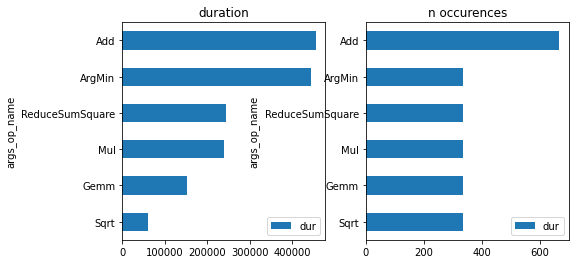

In [13]:
import matplotlib.pyplot as plt
gr_dur = df[['dur', "args_op_name"]].groupby("args_op_name").sum().sort_values('dur')
gr_n = df[['dur', "args_op_name"]].groupby("args_op_name").count().sort_values('dur')
gr_n = gr_n.loc[gr_dur.index, :]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration")
ax[1].set_title("n occurences");

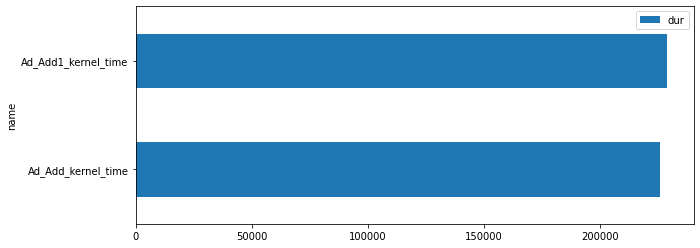

In [14]:
gr2 = df.loc[(df.args_op_name == 'Add') & (df.dur > 10), ['dur', "name"]].groupby("name").sum().sort_values('dur')
gr2.plot.barh(figsize=(10, 4));

### onnxruntime

In [15]:
from onnxruntime import InferenceSession, RunOptions, SessionOptions
so = SessionOptions()
so.enable_profiling = True
sess = InferenceSession(onx.SerializeToString(), so)

In [16]:
for i in range(0, 111):
    sess.run(None, {'X': X.astype(numpy.float32)}, )

In [17]:
prof = sess.end_profiling()
prof

'onnxruntime_profile__2021-05-13_13-58-59.json'

In [18]:
with open(prof, "r") as f:
    js = json.load(f)
    
js[:3]

[{'cat': 'Session',
  'pid': 106368,
  'tid': 299276,
  'dur': 450,
  'ts': 6,
  'ph': 'X',
  'name': 'model_loading_array',
  'args': {}},
 {'cat': 'Session',
  'pid': 106368,
  'tid': 299276,
  'dur': 3068,
  'ts': 498,
  'ph': 'X',
  'name': 'session_initialization',
  'args': {}},
 {'cat': 'Node',
  'pid': 106368,
  'tid': 299276,
  'dur': 1,
  'ts': 39069,
  'ph': 'X',
  'name': 'Re_ReduceSumSquare_fence_before',
  'args': {'op_name': 'ReduceSumSquare'}}]

In [19]:
from pandas import DataFrame
from mlprodict.onnxrt.ops_whole.session import OnnxWholeSession

df = DataFrame(OnnxWholeSession.process_profiling(js))
df

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_provider,args_graph_index,args_parameter_size,args_thread_scheduling_stats,args_exec_plan_index,args_activation_size,args_output_size
0,Session,106368,299276,450,6,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,106368,299276,3068,498,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,106368,299276,1,39069,X,Re_ReduceSumSquare_fence_before,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,106368,299276,2804,39081,X,Re_ReduceSumSquare_kernel_time,ReduceSumSquare,CPUExecutionProvider,0,0,{'main_thread': {'thread_pool_name': 'session-...,0,8000000,400000
4,Node,106368,299276,0,41947,X,Re_ReduceSumSquare_fence_after,ReduceSumSquare,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,Node,106368,299276,0,2530548,X,Ar_ArgMin_fence_before,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2551,Node,106368,299276,3501,2530550,X,Ar_ArgMin_kernel_time,ArgMin,CPUExecutionProvider,5,0,{'main_thread': {'thread_pool_name': 'session-...,5,3200000,800000
2552,Node,106368,299276,0,2534074,X,Ar_ArgMin_fence_after,ArgMin,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2553,Session,106368,299276,14679,2519397,X,SequentialExecutor::Execute,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Einsum: `bsnh,btnh->bnts`

This section looks into the ONNX graph produces by the decomposition of an einsum equation into more simple ONNX operator (no einsum).

### Three implementations

In [20]:
from mlprodict.testing.einsum import einsum as onx_einsum
from mlprodict.testing.einsum.einsum_fct import _einsum, enumerate_cached_einsum
from numpy import einsum as np_einsum

First classic numpy.

In [21]:
equation = "bsnh,btnh->bnts"

N = 2
inputs = [numpy.random.randn(N, N, N, N).astype(numpy.float32),
          numpy.random.randn(N, N, N, N).astype(numpy.float32)]
np_einsum(equation, *inputs)

array([[[[-2.373884  , -0.63942796],
         [ 1.0523143 ,  5.659873  ]],

        [[ 2.589915  , -0.18050319],
         [-0.6200199 ,  3.793615  ]]],


       [[[-0.37409338,  0.19822143],
         [ 1.2049038 ,  3.1882448 ]],

        [[-0.05218329,  0.87404007],
         [ 0.12789296,  1.4745121 ]]]], dtype=float32)

Then einsum executed by *onnxruntime*:

In [22]:
onx_einsum(equation, *inputs, runtime='onnxruntime1', optimize=True, verbose=1, decompose=False)

0.0026 best='sbhn,sthn->shtb': 100%|██████████| 121/121 [00:01<00:00, 85.29it/s]


array([[[[-2.373884  , -0.63942796],
         [ 1.0523144 ,  5.659873  ]],

        [[ 2.589915  , -0.18050319],
         [-0.62002003,  3.793615  ]]],


       [[[-0.37409338,  0.19822143],
         [ 1.2049038 ,  3.1882448 ]],

        [[-0.05218329,  0.87404007],
         [ 0.12789296,  1.474512  ]]]], dtype=float32)

In [23]:
obj = _einsum(equation, runtime='onnxruntime1', optimize=True, verbose=1,
              decompose=False, dtype=inputs[0].dtype)

In [24]:
%onnxview obj.onnx_

Same equation but decomposed.

In [25]:
obj = _einsum(equation, runtime='onnxruntime1', optimize=True, verbose=1,
              decompose=True, dtype=inputs[0].dtype)

0.0025 best='hsnt,hbnt->hnbs': 100%|██████████| 121/121 [00:03<00:00, 34.54it/s]


In [26]:
%onnxview obj.onnx_

In [27]:
onx_einsum(equation, *inputs, runtime='onnxruntime1', optimize=True, verbose=1)

array([[[[-2.373884  , -0.63942796],
         [ 1.0523144 ,  5.659873  ]],

        [[ 2.589915  , -0.18050319],
         [-0.62002003,  3.793615  ]]],


       [[[-0.37409338,  0.19822143],
         [ 1.2049038 ,  3.1882448 ]],

        [[-0.05218329,  0.87404007],
         [ 0.12789296,  1.474512  ]]]], dtype=float32)

### First benchmark

In [28]:
N = 20
inputs = [numpy.random.randn(N, N, N, N).astype(numpy.float32),
          numpy.random.randn(N, N, N, N).astype(numpy.float32)]

*numpy.einsum*

In [29]:
%timeit numpy.einsum(equation, *inputs)

4.14 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


*onnxruntime einsum*

In [30]:
%timeit onx_einsum(equation, *inputs, runtime='onnxruntime1', optimize=True, verbose=1, decompose=False)

736 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


*onnxruntime decomposed einsum*

In [31]:
%timeit onx_einsum(equation, *inputs, runtime='onnxruntime1', optimize=True, verbose=1)

525 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let's disable the optimization to see the difference. The optimization goes through all the permutation of the letters of the equation and compares the computation time to find the best one.

In [32]:
%timeit onx_einsum(equation, *inputs, runtime='onnxruntime1', optimize=False, verbose=1, decompose=False)

761 µs ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


It has no significant impact here but it has for the decomposition. The not optimized version is much slower.

In [33]:
%timeit onx_einsum(equation, *inputs, runtime='onnxruntime1', optimize=False, verbose=1)

1.41 ms ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Profiling of the not optimized version

Let's profile the graph obtained with the decomposition.

In [34]:
obj = _einsum(equation, runtime='onnxruntime1', optimize=False, verbose=1,
              decompose=True, dtype=inputs[0].dtype)
onx = obj.onnx_

In [35]:
obj.equation, obj.equation_

('bsnh,btnh->bnts', 'bsnh,btnh->bnts')

In [36]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(onx, runtime="onnxruntime1",
                     runtime_options={"enable_profiling": True})

d_inputs = {'X0': inputs[0], 'X1': inputs[1]}
for i in range(0, 100):
    oinf.run(d_inputs)
    
df = oinf.get_profiling(as_df=True)
df.head()

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_provider,args_graph_index,args_parameter_size,args_thread_scheduling_stats,args_exec_plan_index,args_activation_size,args_output_size
0,Session,106368,299276,705,4,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,106368,299276,7019,987,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,106368,299276,1,8320,X,Unsqueeze3_2620928306480_fence_before,Unsqueeze,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,106368,299276,4,8327,X,Unsqueeze3_2620928306480_kernel_time,Unsqueeze,CPUExecutionProvider,4,8,{'main_thread': {'thread_pool_name': 'session-...,4,640000,640000
4,Node,106368,299276,0,8372,X,Unsqueeze3_2620928306480_fence_after,Unsqueeze,NaN,NaN,NaN,NaN,NaN,NaN,NaN


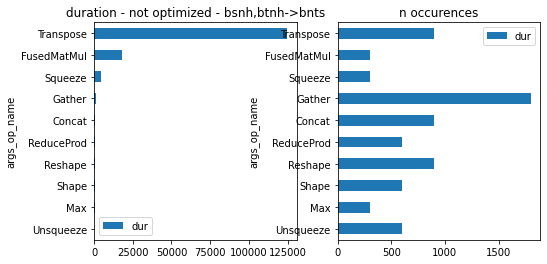

In [37]:
import matplotlib.pyplot as plt
gr_dur = df[['dur', "args_op_name"]].groupby("args_op_name").sum().sort_values('dur')
gr_n = df[['dur', "args_op_name"]].groupby("args_op_name").count().sort_values('dur')
gr_n = gr_n.loc[gr_dur.index, :]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration - not optimized - %s" % obj.equation_)
ax[1].set_title("n occurences");

### Profiling of the optimized version

In [38]:
obj = _einsum(equation, runtime='onnxruntime1', optimize=True, verbose=1,
              decompose=True, dtype=inputs[0].dtype)
onx = obj.onnx_

In [39]:
obj.equation, obj.equation_

('bsnh,btnh->bnts', 'hsnt,hbnt->hnbs')

The second equation is the optimized equation.

In [40]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(onx, runtime="onnxruntime1",
                     runtime_options={"enable_profiling": True})

d_inputs = {'X0': inputs[0], 'X1': inputs[1]}
for i in range(0, 100):
    oinf.run(d_inputs)
    
df = oinf.get_profiling(as_df=True)
df.head()

,cat,pid,tid,dur,ts,ph,name,args_op_name,args_provider,args_graph_index,args_parameter_size,args_thread_scheduling_stats,args_exec_plan_index,args_activation_size,args_output_size
0,Session,106368,299276,1300,6,X,model_loading_array,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Session,106368,299276,7330,1720,X,session_initialization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Node,106368,299276,1,9376,X,Unsqueeze3_2620928202160_fence_before,Unsqueeze,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Node,106368,299276,4,9383,X,Unsqueeze3_2620928202160_kernel_time,Unsqueeze,CPUExecutionProvider,4,8,{'main_thread': {'thread_pool_name': 'session-...,4,640000,640000
4,Node,106368,299276,0,9422,X,Unsqueeze3_2620928202160_fence_after,Unsqueeze,NaN,NaN,NaN,NaN,NaN,NaN,NaN


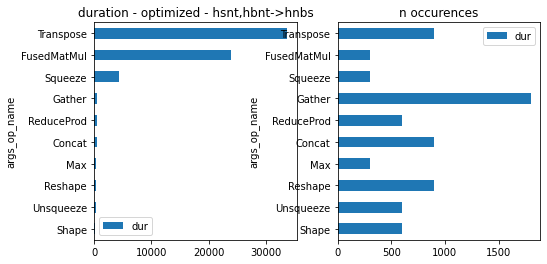

In [41]:
gr_dur = df[['dur', "args_op_name"]].groupby("args_op_name").sum().sort_values('dur')
gr_n = df[['dur', "args_op_name"]].groupby("args_op_name").count().sort_values('dur')
gr_n = gr_n.loc[gr_dur.index, :]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
gr_dur.plot.barh(ax=ax[0])
gr_n.plot.barh(ax=ax[1])
ax[0].set_title("duration - optimized - %s" % obj.equation_)
ax[1].set_title("n occurences");

onnxruntime was able to fuse MatMul with a transposition. That explains why it is faster.

In [42]:
gr_dur = df[['dur', "args_op_name", "name"]].groupby(["args_op_name", "name"], as_index=False).sum().sort_values('dur')
gr_dur

,args_op_name,name,dur
0,Concat,Concat12_fence_after,0
24,Gather,Gather1_fence_after,0
25,Gather,Gather1_fence_before,0
27,Gather,Gather_fence_after,0
60,Transpose,Transpose02134_2620928192768_fence_after,0
...,...,...,...
56,Squeeze,Squeeze4_2620928194352_kernel_time,4339
59,Transpose,Transpose01324_2620928151024_kernel_time,8661
62,Transpose,Transpose02134_2620928192768_kernel_time,11487
65,Transpose,Transpose13024_2620928192816_kernel_time,13598


In [43]:
gr_dur[gr_dur.args_op_name == "Transpose"]

,args_op_name,name,dur
60,Transpose,Transpose02134_2620928192768_fence_after,0
57,Transpose,Transpose01324_2620928151024_fence_after,0
61,Transpose,Transpose02134_2620928192768_fence_before,0
58,Transpose,Transpose01324_2620928151024_fence_before,1
64,Transpose,Transpose13024_2620928192816_fence_before,1
63,Transpose,Transpose13024_2620928192816_fence_after,3
59,Transpose,Transpose01324_2620928151024_kernel_time,8661
62,Transpose,Transpose02134_2620928192768_kernel_time,11487
65,Transpose,Transpose13024_2620928192816_kernel_time,13598


Let's draw again the graph to see which transpose is is which.

In [44]:
%onnxview onx

The optimized looked into all permutations. We see that the letter ordering should be carefully chosen.

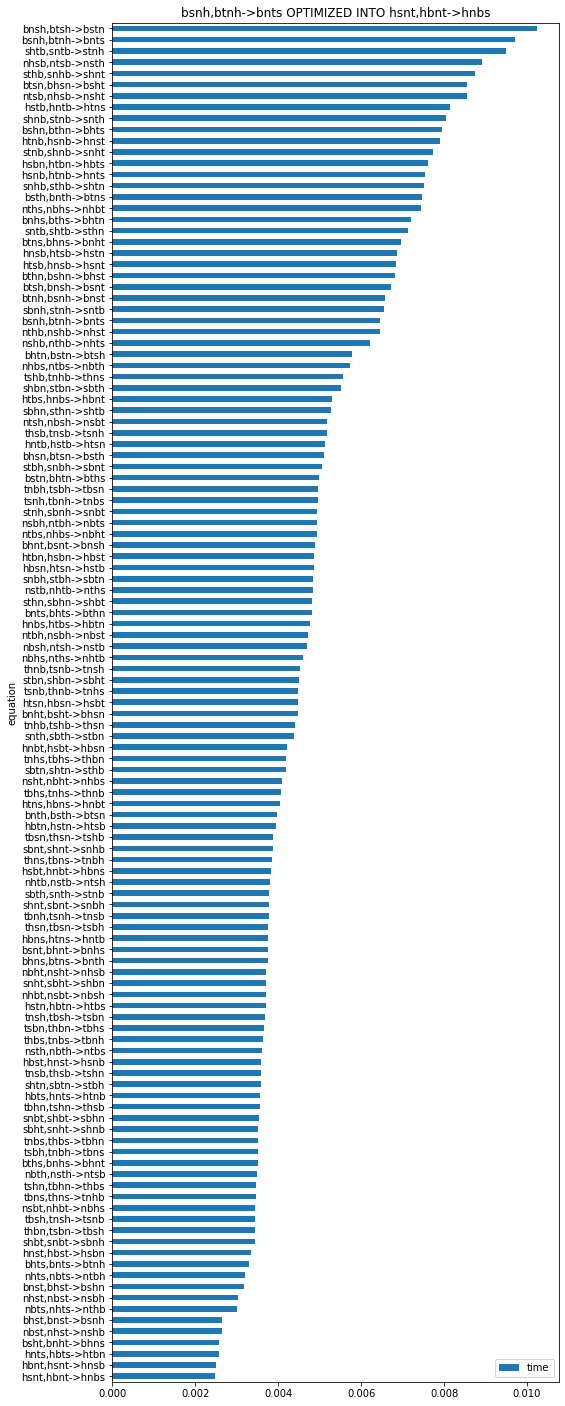

In [45]:
import pandas
df = pandas.DataFrame(obj.timed_permutations_, columns=["time", "equation"])
df = df.sort_values('time')
df = df.set_index("equation")
ax = df.plot.barh(figsize=(8, 25))
ax.set_title("%s OPTIMIZED INTO %s" % (obj.equation, obj.equation_));